# AGH Web graph

#### Import packages, load graphs data 

In [1]:
import json
import glob
from urllib.parse import urlparse

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = "/Users/wnowogorski/PycharmProjects/ChatAGH_DataCollecting/graphs"


def load_file(file):
    try:
        with open(file) as f:
            data = json.load(f)
        df = pd.DataFrame(data["edges"])
        for prefix in (r"^https://", r"www.", r"[\\/]+$"):
            df["source"] = df["source"].str.replace(prefix, "", regex=True)
            df["target"] = df["target"].str.replace(prefix, "", regex=True)
    except Exception as e:
        raise Exception(f"Failed to load: {file}: {e}")

    return df


files = glob.glob(f"{DATA_DIR}/*.json")
graph = pd.concat([load_file(f) for f in files], ignore_index=True)


def get_domain(url):
    if not url.startswith(("http://", "https://")):
        url = "http://" + url
    return urlparse(url).netloc


graph["source_domain"] = graph["source"].map(get_domain)
graph["target_domain"] = graph["target"].map(get_domain)

excluded_domains = ["open.agh.edu.pl", "zasoby.open.agh.edu.pl", "badap.agh.edu.pl"]
graph = graph[~graph["source_domain"].isin(excluded_domains)]

scraped_domains = set(graph["source_domain"].unique())
graph = graph[graph["target_domain"].isin(scraped_domains)].copy()
graph.reset_index(drop=True, inplace=True)

print(f"Filtered to {len(graph):,} internal links between scraped domains.")
print(f"Unique domains: {graph['source_domain'].nunique()}")

graph.info()

Filtered to 483,722 internal links between scraped domains.
Unique domains: 43
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483722 entries, 0 to 483721
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   source         483722 non-null  object
 1   target         483722 non-null  object
 2   source_domain  483722 non-null  object
 3   target_domain  483722 non-null  object
dtypes: object(4)
memory usage: 14.8+ MB


## Exploratory Data Analysis

In [2]:
G = nx.from_pandas_edgelist(
    graph, source="source_domain", target="target_domain", create_using=nx.DiGraph()
)

#### Web graph overview

In [3]:
print("=" * 60)
print("NETWORK OVERVIEW")
print("=" * 60)
print(f"Number of nodes (domains): {G.number_of_nodes():,}")
print(f"Number of edges (links): {G.number_of_edges():,}")
print(f"Graph density: {nx.density(G):.4f}")
print(f"Is strongly connected: {nx.is_strongly_connected(G)}")
print(f"Is weakly connected: {nx.is_weakly_connected(G)}")

NETWORK OVERVIEW
Number of nodes (domains): 43
Number of edges (links): 335
Graph density: 0.1855
Is strongly connected: False
Is weakly connected: True


### Domain-level graph visualization

In [ ]:
G_vis = G
pos = nx.spring_layout(G_vis, k=2, iterations=50, seed=42)

node_degrees = dict(G_vis.degree())
node_sizes = [node_degrees[node] * 20 + 100 for node in G_vis.nodes()]
in_degrees_vis = dict(G_vis.in_degree())
node_colors = [in_degrees_vis[node] for node in G_vis.nodes()]

fig, ax = plt.subplots(figsize=(20, 16))
nx.draw_networkx_edges(
    G_vis,
    pos,
    alpha=0.2,
    width=0.5,
    edge_color="gray",
    arrows=True,
    arrowsize=10,
    arrowstyle="->",
    connectionstyle="arc3,rad=0.1",
    ax=ax,
)
nodes = nx.draw_networkx_nodes(
    G_vis,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap="YlOrRd",
    alpha=0.8,
    edgecolors="black",
    linewidths=1.5,
    ax=ax,
)
high_degree_nodes = {
    node: label
    for node, label in zip(G_vis.nodes(), G_vis.nodes())
    if node_degrees[node] > np.percentile(list(node_degrees.values()), 50)
}
nx.draw_networkx_labels(
    G_vis, pos, labels=high_degree_nodes, font_size=12, font_weight="bold", ax=ax
)
sm = plt.cm.ScalarMappable(
    cmap="YlOrRd", norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("In-Degree (Times Referenced)", fontsize=12, fontweight="bold")
ax.set_title(
    "AGH Web Data Network Visualization\n(Node size = total degree, Color = in-degree, Top 20% labeled)",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
ax.axis("off")
plt.tight_layout()
plt.show()

### Most important domains

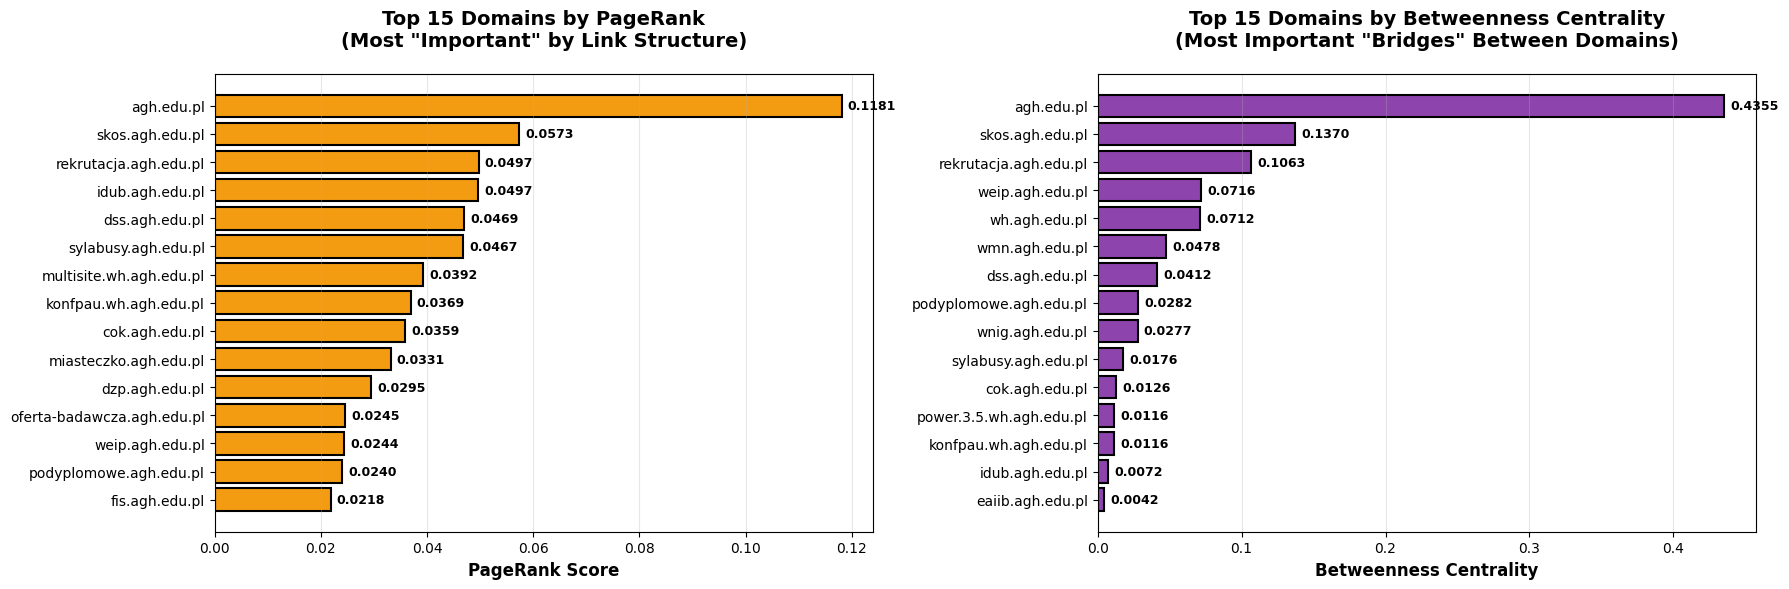

In [5]:
pagerank = nx.pagerank(G, alpha=0.85)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:15]

betweenness = nx.betweenness_centrality(
    G, k=min(100, G.number_of_nodes())
)  # Sample for speed
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:15]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

domains_pr = [d[0] for d in top_pagerank]
values_pr = [d[1] for d in top_pagerank]
axes[0].barh(
    range(len(domains_pr)), values_pr, color="#f39c12", edgecolor="black", linewidth=1.5
)
axes[0].set_yticks(range(len(domains_pr)))
axes[0].set_yticklabels(domains_pr, fontsize=10)
axes[0].set_xlabel("PageRank Score", fontsize=12, fontweight="bold")
axes[0].set_title(
    'Top 15 Domains by PageRank\n(Most "Important" by Link Structure)',
    fontsize=14,
    fontweight="bold",
    pad=20,
)
axes[0].invert_yaxis()
axes[0].grid(axis="x", alpha=0.3)
for i, v in enumerate(values_pr):
    axes[0].text(
        v + max(values_pr) * 0.01,
        i,
        f"{v:.4f}",
        va="center",
        fontweight="bold",
        fontsize=9,
    )
domains_bc = [d[0] for d in top_betweenness]
values_bc = [d[1] for d in top_betweenness]
axes[1].barh(
    range(len(domains_bc)), values_bc, color="#8e44ad", edgecolor="black", linewidth=1.5
)
axes[1].set_yticks(range(len(domains_bc)))
axes[1].set_yticklabels(domains_bc, fontsize=10)
axes[1].set_xlabel("Betweenness Centrality", fontsize=12, fontweight="bold")
axes[1].set_title(
    'Top 15 Domains by Betweenness Centrality\n(Most Important "Bridges" Between Domains)',
    fontsize=14,
    fontweight="bold",
    pad=20,
)
axes[1].invert_yaxis()
axes[1].grid(axis="x", alpha=0.3)
for i, v in enumerate(values_bc):
    axes[1].text(
        v + max(values_bc) * 0.01,
        i,
        f"{v:.4f}",
        va="center",
        fontweight="bold",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

### Clustering coefficient

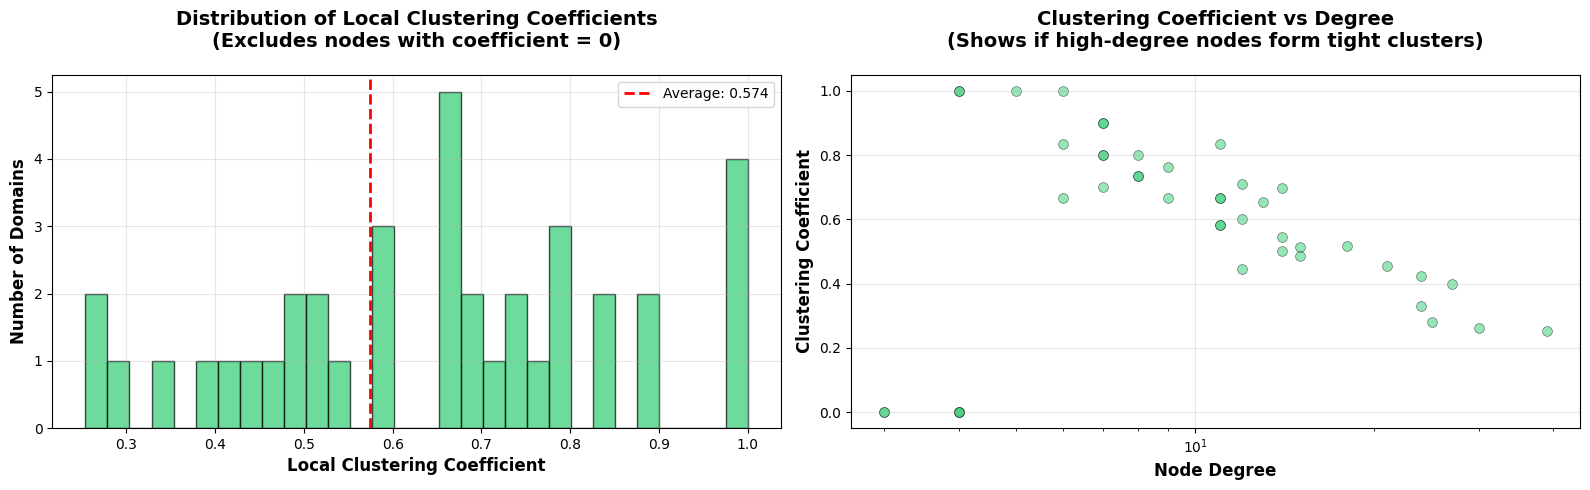


Top 10 Domains by Clustering Coefficient (most embedded in tight groups):
  informatyka.podyplomowe.agh.edu.pl: 1.0000
  ckim.agh.edu.pl: 1.0000
  swfis.agh.edu.pl: 1.0000
  old.skos.agh.edu.pl: 1.0000
  test.wnig.agh.edu.pl: 0.9000
  szkolenia.agh.edu.pl: 0.9000
  cwp.agh.edu.pl: 0.8333
  fis.agh.edu.pl: 0.8333
  oferta-badawcza.agh.edu.pl: 0.8000
  rownosc.agh.edu.pl: 0.8000


In [6]:
G_undirected = G.to_undirected()
clustering_coeffs = nx.clustering(G_undirected)
avg_clustering = nx.average_clustering(G_undirected)

transitivity = nx.transitivity(G_undirected)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

clustering_values = list(clustering_coeffs.values())
axes[0].hist(
    [c for c in clustering_values if c > 0],
    bins=30,
    color="#2ecc71",
    alpha=0.7,
    edgecolor="black",
)
axes[0].set_xlabel("Local Clustering Coefficient", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Number of Domains", fontsize=12, fontweight="bold")
axes[0].set_title(
    "Distribution of Local Clustering Coefficients\n(Excludes nodes with coefficient = 0)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
axes[0].axvline(
    avg_clustering,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Average: {avg_clustering:.3f}",
)
axes[0].legend()
axes[0].grid(alpha=0.3)

degrees = [d for n, d in G_undirected.degree()]
clustering_by_node = [clustering_coeffs[n] for n in G_undirected.nodes()]

axes[1].scatter(
    degrees,
    clustering_by_node,
    alpha=0.5,
    s=50,
    color="#2ecc71",
    edgecolors="black",
    linewidth=0.5,
)
axes[1].set_xlabel("Node Degree", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Clustering Coefficient", fontsize=12, fontweight="bold")
axes[1].set_title(
    "Clustering Coefficient vs Degree\n(Shows if high-degree nodes form tight clusters)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
axes[1].grid(alpha=0.3)
axes[1].set_xscale("log")

plt.tight_layout()
plt.show()

top_clustering = sorted(clustering_coeffs.items(), key=lambda x: x[1], reverse=True)[
    :10
]
print("\nTop 10 Domains by Clustering Coefficient (most embedded in tight groups):")
for domain, coeff in top_clustering:
    if coeff > 0:
        print(f"  {domain}: {coeff:.4f}")

### Links - graph edges


Link Weight Statistics:
Total unique domain pairs: 335
Mean links per pair: 1443.95
Median links per pair: 20.0
Max links between a pair: 37355
Pairs with multiple links: 286 (85.4%)


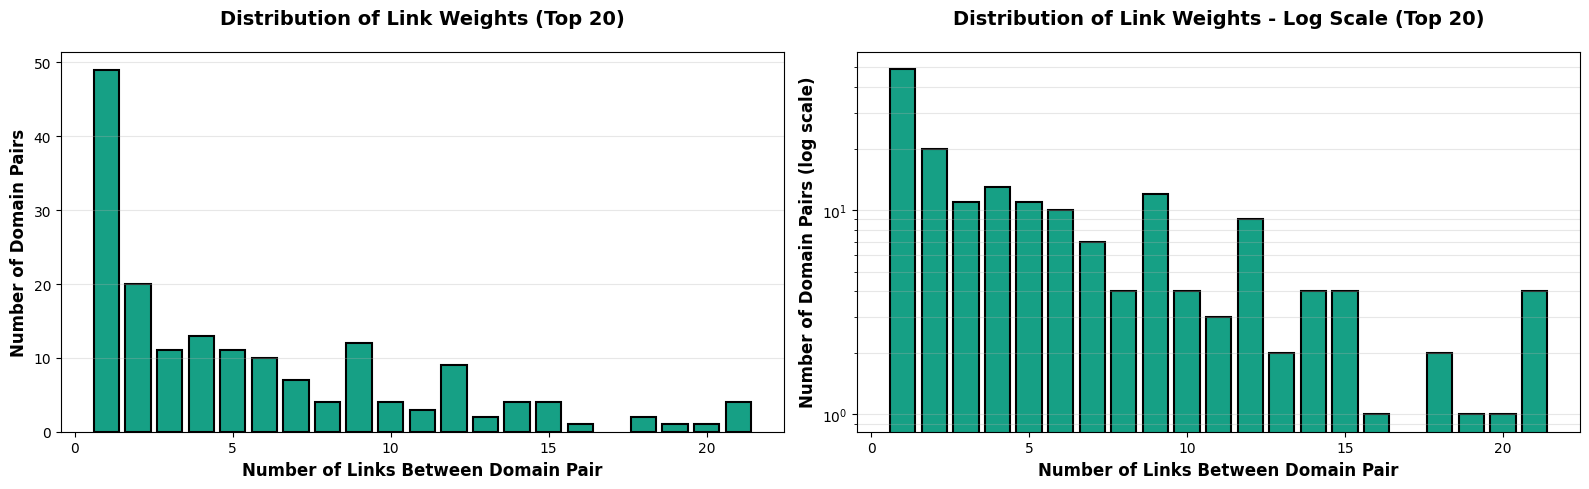

In [7]:
edge_weights = (
    graph.groupby(["source_domain", "target_domain"]).size().reset_index(name="weight")
)

print("\nLink Weight Statistics:")
print(f"Total unique domain pairs: {len(edge_weights):,}")
print(f"Mean links per pair: {edge_weights['weight'].mean():.2f}")
print(f"Median links per pair: {edge_weights['weight'].median():.1f}")
print(f"Max links between a pair: {edge_weights['weight'].max()}")
print(
    f"Pairs with multiple links: {(edge_weights['weight'] > 1).sum():,} ({(edge_weights['weight'] > 1).sum() / len(edge_weights) * 100:.1f}%)"
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

weight_counts = edge_weights["weight"].value_counts().sort_index()
axes[0].bar(
    weight_counts.index[:20],
    weight_counts.values[:20],
    color="#16a085",
    edgecolor="black",
    linewidth=1.5,
)
axes[0].set_xlabel(
    "Number of Links Between Domain Pair", fontsize=12, fontweight="bold"
)
axes[0].set_ylabel("Number of Domain Pairs", fontsize=12, fontweight="bold")
axes[0].set_title(
    "Distribution of Link Weights (Top 20)", fontsize=14, fontweight="bold", pad=20
)
axes[0].grid(axis="y", alpha=0.3)

axes[1].bar(
    weight_counts.index[:20],
    weight_counts.values[:20],
    color="#16a085",
    edgecolor="black",
    linewidth=1.5,
)
axes[1].set_xlabel(
    "Number of Links Between Domain Pair", fontsize=12, fontweight="bold"
)
axes[1].set_ylabel("Number of Domain Pairs (log scale)", fontsize=12, fontweight="bold")
axes[1].set_title(
    "Distribution of Link Weights - Log Scale (Top 20)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
axes[1].set_yscale("log")
axes[1].grid(axis="y", alpha=0.3, which="both")

plt.tight_layout()
plt.show()

In [8]:
reciprocal_edges = []
for source, target in G.edges():
    if G.has_edge(target, source):
        # Only add once (avoid duplicates)
        if (target, source) not in reciprocal_edges:
            reciprocal_edges.append((source, target))

print("\nReciprocal Connections:")
print(f"Total reciprocal pairs: {len(reciprocal_edges):,}")
print(
    f"Percentage of edges that are reciprocal: {len(reciprocal_edges) * 2 / G.number_of_edges() * 100:.2f}%"
)


Reciprocal Connections:
Total reciprocal pairs: 123
Percentage of edges that are reciprocal: 73.43%


### Most Referenced/Referencing domains

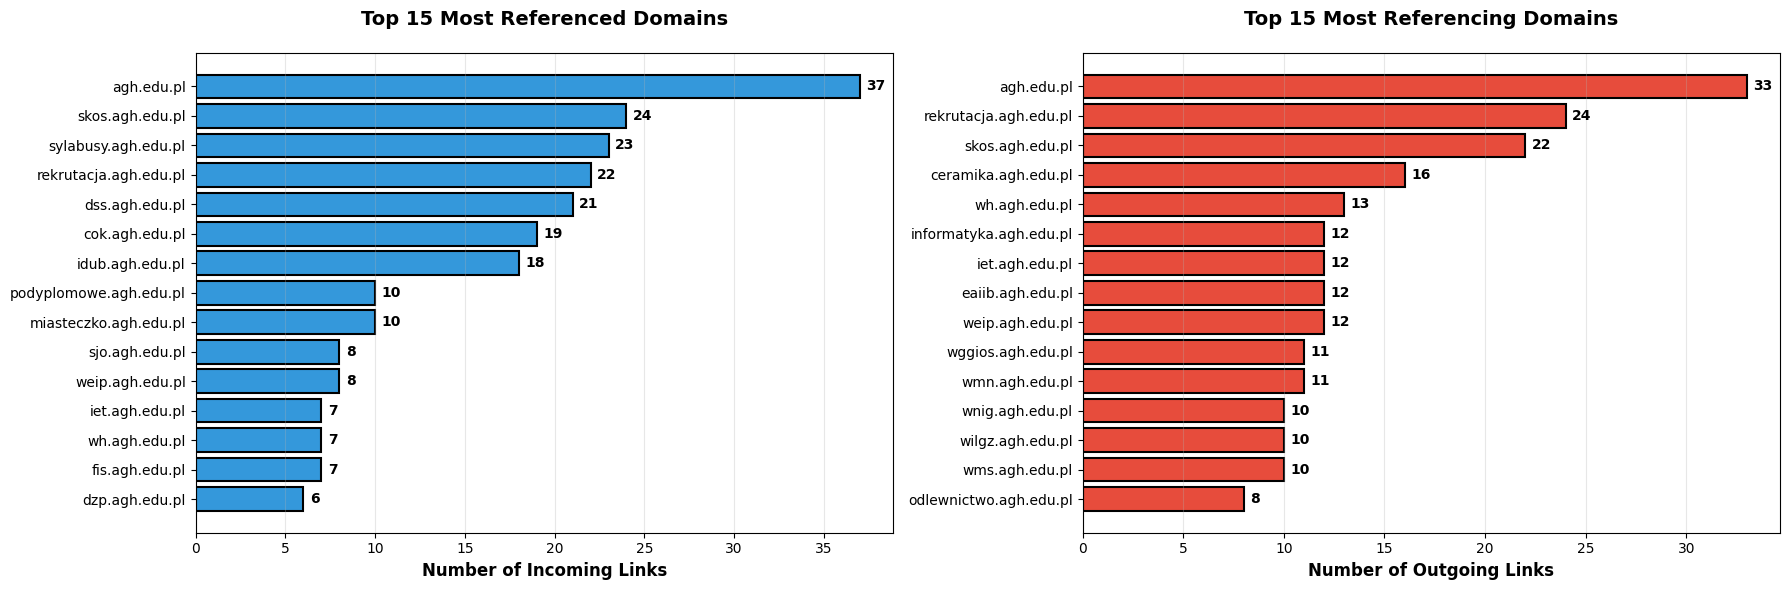

In [9]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
total_degrees = dict(G.degree())

top_n = 15

top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

domains_in = [d[0] for d in top_in_degree]
values_in = [d[1] for d in top_in_degree]

axes[0].barh(
    range(len(domains_in)), values_in, color="#3498db", edgecolor="black", linewidth=1.5
)
axes[0].set_yticks(range(len(domains_in)))
axes[0].set_yticklabels(domains_in, fontsize=10)
axes[0].set_xlabel("Number of Incoming Links", fontsize=12, fontweight="bold")
axes[0].set_title(
    f"Top {top_n} Most Referenced Domains", fontsize=14, fontweight="bold", pad=20
)
axes[0].invert_yaxis()
axes[0].grid(axis="x", alpha=0.3)

for i, v in enumerate(values_in):
    axes[0].text(v + max(values_in) * 0.01, i, str(v), va="center", fontweight="bold")

domains_out = [d[0] for d in top_out_degree]
values_out = [d[1] for d in top_out_degree]

axes[1].barh(
    range(len(domains_out)),
    values_out,
    color="#e74c3c",
    edgecolor="black",
    linewidth=1.5,
)
axes[1].set_yticks(range(len(domains_out)))
axes[1].set_yticklabels(domains_out, fontsize=10)
axes[1].set_xlabel("Number of Outgoing Links", fontsize=12, fontweight="bold")
axes[1].set_title(
    f"Top {top_n} Most Referencing Domains", fontsize=14, fontweight="bold", pad=20
)
axes[1].invert_yaxis()
axes[1].grid(axis="x", alpha=0.3)

for i, v in enumerate(values_out):
    axes[1].text(v + max(values_out) * 0.01, i, str(v), va="center", fontweight="bold")

plt.tight_layout()
plt.show()

## Feature engineering

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
all_domains = list(G.nodes())
n_domains = len(all_domains)
domain_to_idx = {domain: idx for idx, domain in enumerate(all_domains)}

In [12]:
outlink_sets = {}
for domain in all_domains:
    outlink_sets[domain] = set(G.successors(domain))

outlink_jaccard = np.zeros((n_domains, n_domains))

for i, domain1 in enumerate(all_domains):
    for j, domain2 in enumerate(all_domains):
        if i <= j:
            if len(outlink_sets[domain1]) == 0 and len(outlink_sets[domain2]) == 0:
                similarity = 0
            elif len(outlink_sets[domain1]) == 0 or len(outlink_sets[domain2]) == 0:
                similarity = 0
            else:
                intersection = len(outlink_sets[domain1] & outlink_sets[domain2])
                union = len(outlink_sets[domain1] | outlink_sets[domain2])
                similarity = intersection / union if union > 0 else 0

            outlink_jaccard[i, j] = similarity
            outlink_jaccard[j, i] = similarity  # Symmetric

In [13]:
outlink_matrix = np.zeros((n_domains, n_domains))
for i, domain in enumerate(all_domains):
    for target in outlink_sets[domain]:
        if target in domain_to_idx:
            j = domain_to_idx[target]
            outlink_matrix[i, j] = 1

outlink_cosine = cosine_similarity(outlink_matrix)

print("✓ Shared outlinks similarity computed")
print(
    f"  - Mean Jaccard similarity: {outlink_jaccard[np.triu_indices(n_domains, k=1)].mean():.4f}"
)
print(
    f"  - Mean Cosine similarity: {outlink_cosine[np.triu_indices(n_domains, k=1)].mean():.4f}"
)
print(f"  - Non-zero Jaccard pairs: {(outlink_jaccard > 0).sum() // 2:,}")
print(f"  - Non-zero Cosine pairs: {(outlink_cosine > 0).sum() // 2:,}")

✓ Shared outlinks similarity computed
  - Mean Jaccard similarity: 0.1943
  - Mean Cosine similarity: 0.3204
  - Non-zero Jaccard pairs: 724
  - Non-zero Cosine pairs: 724


In [14]:
inlink_sets = {}
for domain in all_domains:
    inlink_sets[domain] = set(G.predecessors(domain))

inlink_jaccard = np.zeros((n_domains, n_domains))

for i, domain1 in enumerate(all_domains):
    for j, domain2 in enumerate(all_domains):
        if i <= j:
            if len(inlink_sets[domain1]) == 0 and len(inlink_sets[domain2]) == 0:
                similarity = 0
            elif len(inlink_sets[domain1]) == 0 or len(inlink_sets[domain2]) == 0:
                similarity = 0
            else:
                intersection = len(inlink_sets[domain1] & inlink_sets[domain2])
                union = len(inlink_sets[domain1] | inlink_sets[domain2])
                similarity = intersection / union if union > 0 else 0

            inlink_jaccard[i, j] = similarity
            inlink_jaccard[j, i] = similarity

    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{n_domains} domains...")

inlink_matrix = np.zeros((n_domains, n_domains))
for i, domain in enumerate(all_domains):
    for source in inlink_sets[domain]:
        if source in domain_to_idx:
            j = domain_to_idx[source]
            inlink_matrix[i, j] = 1

inlink_cosine = cosine_similarity(inlink_matrix)

print("✓ Shared inlinks similarity computed")
print(
    f"  - Mean Jaccard similarity: {inlink_jaccard[np.triu_indices(n_domains, k=1)].mean():.4f}"
)
print(
    f"  - Mean Cosine similarity: {inlink_cosine[np.triu_indices(n_domains, k=1)].mean():.4f}"
)
print(f"  - Non-zero Jaccard pairs: {(inlink_jaccard > 0).sum() // 2:,}")
print(f"  - Non-zero Cosine pairs: {(inlink_cosine > 0).sum() // 2:,}")

✓ Shared inlinks similarity computed
  - Mean Jaccard similarity: 0.1590
  - Mean Cosine similarity: 0.2724
  - Non-zero Jaccard pairs: 668
  - Non-zero Cosine pairs: 668


In [15]:
direct_weights = np.zeros((n_domains, n_domains))
for idx, row in edge_weights.iterrows():
    source = row["source_domain"]
    target = row["target_domain"]
    weight = row["weight"]

    if source in domain_to_idx and target in domain_to_idx:
        i = domain_to_idx[source]
        j = domain_to_idx[target]
        direct_weights[i, j] = weight

direct_weights_symmetric = direct_weights + direct_weights.T
direct_weights_normalized = (
    direct_weights_symmetric / direct_weights_symmetric.max()
    if direct_weights_symmetric.max() > 0
    else direct_weights_symmetric
)

print("✓ Direct link weights computed")
print(f"  - Total non-zero connections: {(direct_weights_symmetric > 0).sum() // 2:,}")
print(
    f"  - Mean weight (non-zero): {direct_weights_symmetric[direct_weights_symmetric > 0].mean():.2f}"
)
print(f"  - Max weight: {direct_weights_symmetric.max():.0f}")

✓ Direct link weights computed
  - Total non-zero connections: 233
  - Mean weight (non-zero): 2071.61
  - Max weight: 74710


In [16]:
transition_matrix = np.zeros((n_domains, n_domains))
for i, domain in enumerate(all_domains):
    out_degree = len(outlink_sets[domain])
    if out_degree > 0:
        for target in outlink_sets[domain]:
            if target in domain_to_idx:
                j = domain_to_idx[target]
                transition_matrix[i, j] = 1.0 / out_degree

k_steps = 3
random_walk_prob = np.linalg.matrix_power(transition_matrix, k_steps)
random_walk_symmetric = (random_walk_prob + random_walk_prob.T) / 2

print(f"✓ Random walk probabilities computed ({k_steps}-step)")
print(
    f"  - Mean probability (non-zero): {random_walk_symmetric[random_walk_symmetric > 0].mean():.6f}"
)
print(f"  - Non-zero connections: {(random_walk_symmetric > 0).sum() // 2:,}")
print(f"  - Max probability: {random_walk_symmetric.max():.6f}")

✓ Random walk probabilities computed (3-step)
  - Mean probability (non-zero): 0.024308
  - Non-zero connections: 884
  - Max probability: 0.500000


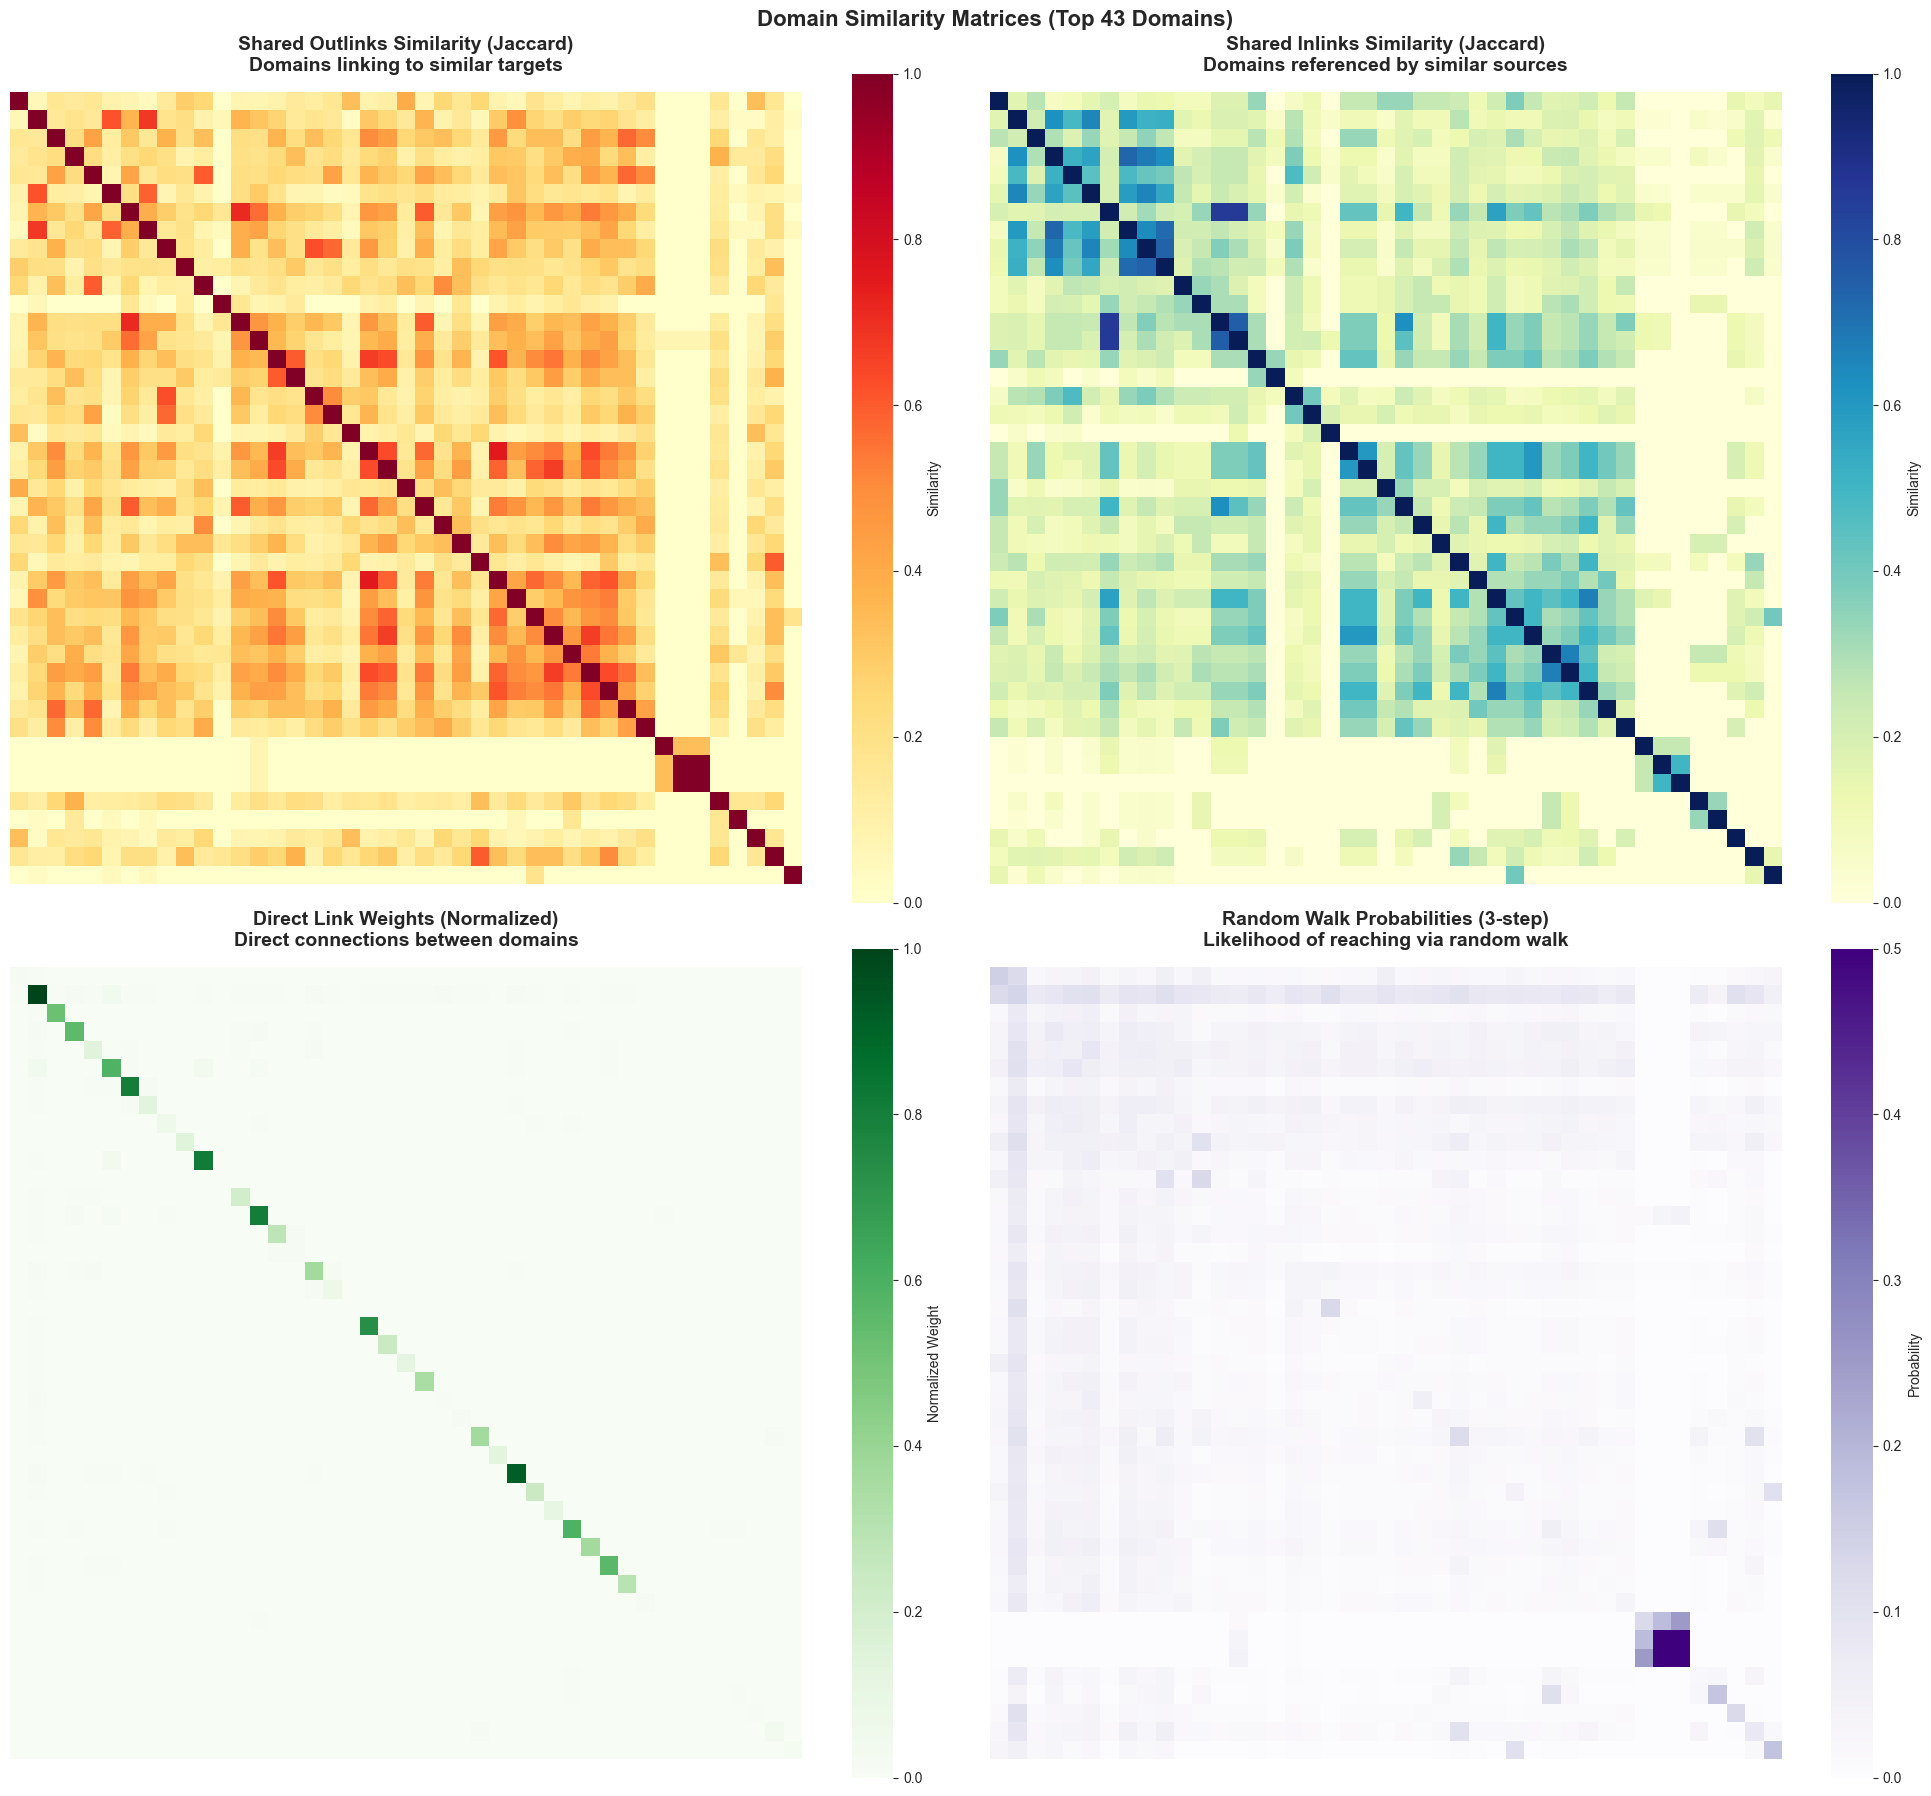

In [17]:
sns.set_style("white")
max_vis_domains = 50
if n_domains > max_vis_domains:
    top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:max_vis_domains]
    vis_domain_names = [n[0] for n in top_nodes]
    vis_indices = [domain_to_idx[d] for d in vis_domain_names]
    print(f"\nVisualizing top {max_vis_domains} domains by degree for clarity")
else:
    vis_indices = list(range(n_domains))
    vis_domain_names = all_domains

vis_outlink_jaccard = outlink_jaccard[np.ix_(vis_indices, vis_indices)]
vis_inlink_jaccard = inlink_jaccard[np.ix_(vis_indices, vis_indices)]
vis_direct_weights = direct_weights_normalized[np.ix_(vis_indices, vis_indices)]
vis_random_walk = random_walk_symmetric[np.ix_(vis_indices, vis_indices)]

fig, axes = plt.subplots(2, 2, figsize=(20, 18))
sns.heatmap(
    vis_outlink_jaccard,
    cmap="YlOrRd",
    square=True,
    cbar_kws={"label": "Similarity"},
    ax=axes[0, 0],
    xticklabels=False,
    yticklabels=False,
    vmin=0,
    vmax=1,
)
axes[0, 0].set_title(
    "Shared Outlinks Similarity (Jaccard)\nDomains linking to similar targets",
    fontsize=14,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    vis_inlink_jaccard,
    cmap="YlGnBu",
    square=True,
    cbar_kws={"label": "Similarity"},
    ax=axes[0, 1],
    xticklabels=False,
    yticklabels=False,
    vmin=0,
    vmax=1,
)
axes[0, 1].set_title(
    "Shared Inlinks Similarity (Jaccard)\nDomains referenced by similar sources",
    fontsize=14,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    vis_direct_weights,
    cmap="Greens",
    square=True,
    cbar_kws={"label": "Normalized Weight"},
    ax=axes[1, 0],
    xticklabels=False,
    yticklabels=False,
    vmin=0,
)
axes[1, 0].set_title(
    "Direct Link Weights (Normalized)\nDirect connections between domains",
    fontsize=14,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    vis_random_walk,
    cmap="Purples",
    square=True,
    cbar_kws={"label": "Probability"},
    ax=axes[1, 1],
    xticklabels=False,
    yticklabels=False,
    vmin=0,
)
axes[1, 1].set_title(
    f"Random Walk Probabilities ({k_steps}-step)\nLikelihood of reaching via random walk",
    fontsize=14,
    fontweight="bold",
    pad=15,
)

plt.suptitle(
    f"Domain Similarity Matrices (Top {len(vis_domain_names)} Domains)",
    fontsize=16,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()


CORRELATION ANALYSIS

Correlation between similarity metrics:
                 Outlink_Jaccard  Outlink_Cosine  Inlink_Jaccard  \
Outlink_Jaccard            1.000           0.970           0.610   
Outlink_Cosine             0.970           1.000           0.613   
Inlink_Jaccard             0.610           0.613           1.000   
Inlink_Cosine              0.621           0.650           0.963   
Direct_Weight              0.141           0.172           0.166   
Random_Walk                0.276           0.322           0.299   

                 Inlink_Cosine  Direct_Weight  Random_Walk  
Outlink_Jaccard          0.621          0.141        0.276  
Outlink_Cosine           0.650          0.172        0.322  
Inlink_Jaccard           0.963          0.166        0.299  
Inlink_Cosine            1.000          0.224        0.389  
Direct_Weight            0.224          1.000        0.352  
Random_Walk              0.389          0.352        1.000  


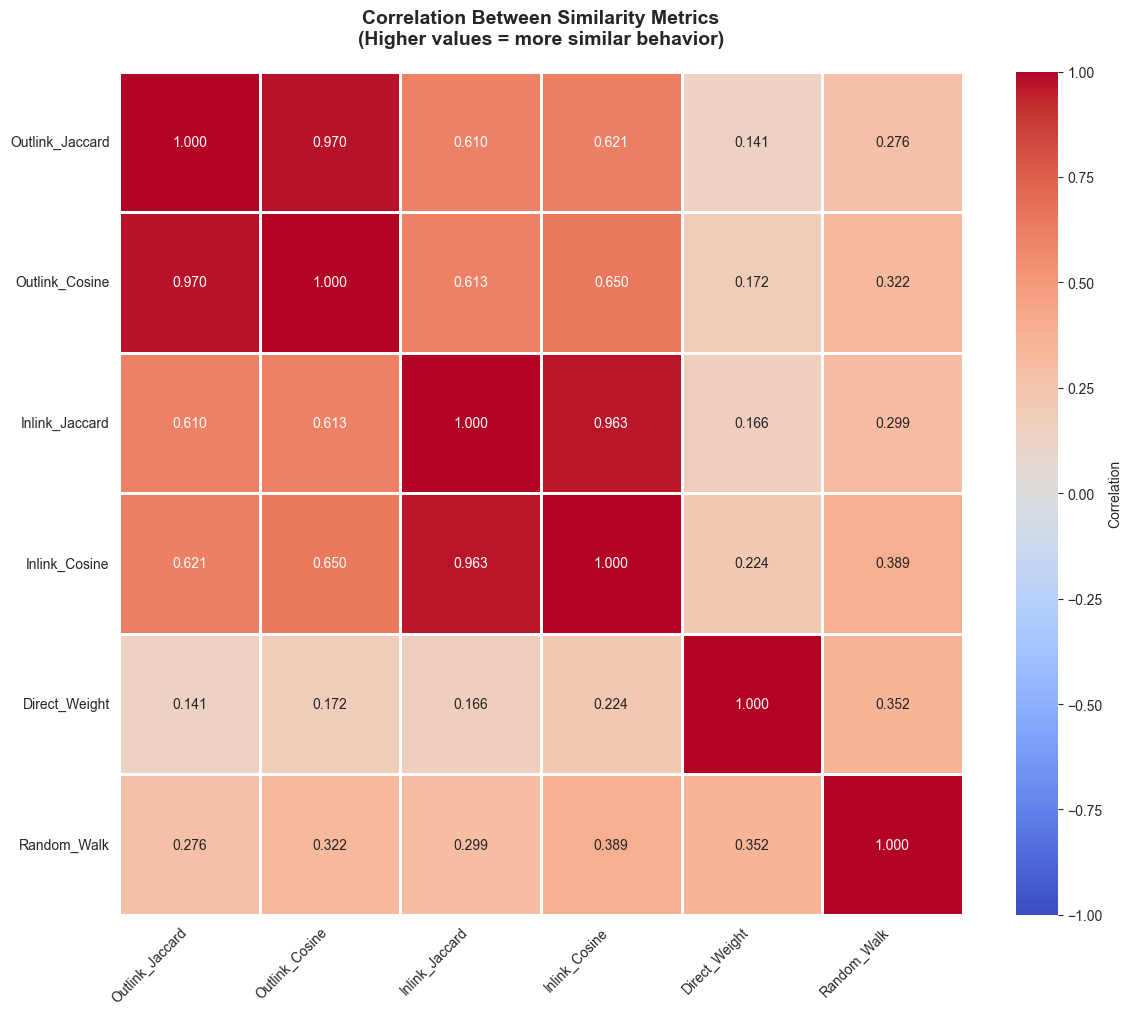


Key Observations:
- High correlation (>0.7): Metrics capture similar information
- Low correlation (<0.3): Metrics capture different aspects
- Negative correlation: Metrics capture opposite patterns

NORMALIZATION


In [18]:
print("\n" + "=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

triu_indices = np.triu_indices(n_domains, k=1)

similarity_data = pd.DataFrame(
    {
        "Outlink_Jaccard": outlink_jaccard[triu_indices],
        "Outlink_Cosine": outlink_cosine[triu_indices],
        "Inlink_Jaccard": inlink_jaccard[triu_indices],
        "Inlink_Cosine": inlink_cosine[triu_indices],
        "Direct_Weight": direct_weights_normalized[triu_indices],
        "Random_Walk": random_walk_symmetric[triu_indices],
    }
)
correlation_matrix = similarity_data.corr()

print("\nCorrelation between similarity metrics:")
print(correlation_matrix.round(3))

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=2,
    cbar_kws={"label": "Correlation"},
    vmin=-1,
    vmax=1,
    ax=ax,
)

ax.set_title(
    "Correlation Between Similarity Metrics\n(Higher values = more similar behavior)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- High correlation (>0.7): Metrics capture similar information")
print("- Low correlation (<0.3): Metrics capture different aspects")
print("- Negative correlation: Metrics capture opposite patterns")
print("\n" + "=" * 60)
print("NORMALIZATION")
print("=" * 60)

In [19]:
from sklearn.preprocessing import MinMaxScaler


def normalize_matrix(matrix):
    """Normalize matrix to [0, 1] range"""
    matrix_flat = matrix.flatten().reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_flat = scaler.fit_transform(matrix_flat)
    return normalized_flat.reshape(matrix.shape)


outlink_jaccard_norm = outlink_jaccard.copy()
inlink_jaccard_norm = inlink_jaccard.copy()
outlink_cosine_norm = outlink_cosine.copy()
inlink_cosine_norm = inlink_cosine.copy()

direct_weights_norm = normalize_matrix(direct_weights_symmetric)
random_walk_norm = normalize_matrix(random_walk_symmetric)

print("✓ All matrices normalized to [0, 1] range")
print("\nNormalized ranges:")
print(
    f"  Outlink Jaccard: [{outlink_jaccard_norm.min():.3f}, {outlink_jaccard_norm.max():.3f}]"
)
print(
    f"  Inlink Jaccard: [{inlink_jaccard_norm.min():.3f}, {inlink_jaccard_norm.max():.3f}]"
)
print(
    f"  Outlink Cosine: [{outlink_cosine_norm.min():.3f}, {outlink_cosine_norm.max():.3f}]"
)
print(
    f"  Inlink Cosine: [{inlink_cosine_norm.min():.3f}, {inlink_cosine_norm.max():.3f}]"
)
print(
    f"  Direct Weights: [{direct_weights_norm.min():.3f}, {direct_weights_norm.max():.3f}]"
)
print(f"  Random Walk: [{random_walk_norm.min():.3f}, {random_walk_norm.max():.3f}]")
print("\n" + "=" * 60)
print("COMBINED SIMILARITY MATRICES")
print("=" * 60)

combined_equal = (
    outlink_jaccard_norm + inlink_jaccard_norm + direct_weights_norm + random_walk_norm
) / 4

combined_structural = (
    0.2 * outlink_jaccard_norm
    + 0.2 * inlink_jaccard_norm
    + 0.4 * direct_weights_norm
    + 0.2 * random_walk_norm
)

combined_functional = (
    0.35 * outlink_jaccard_norm
    + 0.35 * inlink_jaccard_norm
    + 0.15 * direct_weights_norm
    + 0.15 * random_walk_norm
)

combined_balanced = (
    0.2 * outlink_jaccard_norm
    + 0.15 * outlink_cosine_norm
    + 0.2 * inlink_jaccard_norm
    + 0.15 * inlink_cosine_norm
    + 0.2 * direct_weights_norm
    + 0.1 * random_walk_norm
)

print("\n2. Structural Emphasis (Direct connections prioritized)")
print("   Formula: 0.2*Outlink + 0.2*Inlink + 0.4*Direct + 0.2*Random Walk")
print(f"   Range: [{combined_structural.min():.3f}, {combined_structural.max():.3f}]")
print(f"   Mean: {combined_structural[np.triu_indices(n_domains, k=1)].mean():.3f}")

print("\n3. Functional Similarity (Shared neighbors prioritized)")
print("   Formula: 0.35*Outlink + 0.35*Inlink + 0.15*Direct + 0.15*Random Walk")
print(f"   Range: [{combined_functional.min():.3f}, {combined_functional.max():.3f}]")
print(f"   Mean: {combined_functional[np.triu_indices(n_domains, k=1)].mean():.3f}")

print("\n4. Balanced Multi-Metric")
print("   Formula: 0.2*OutJ + 0.15*OutC + 0.2*InJ + 0.15*InC + 0.2*Direct + 0.1*RW")
print(f"   Range: [{combined_balanced.min():.3f}, {combined_balanced.max():.3f}]")
print(f"   Mean: {combined_balanced[np.triu_indices(n_domains, k=1)].mean():.3f}")

print("\n1. Equal Weight Combination")
print("   Formula: (Outlink + Inlink + Direct + Random Walk) / 4")
print(f"   Range: [{combined_equal.min():.3f}, {combined_equal.max():.3f}]")
print(f"   Mean: {combined_balanced[np.triu_indices(n_domains, k=1)].mean():.3f}")

✓ All matrices normalized to [0, 1] range

Normalized ranges:
  Outlink Jaccard: [0.000, 1.000]
  Inlink Jaccard: [0.000, 1.000]
  Outlink Cosine: [0.000, 1.000]
  Inlink Cosine: [0.000, 1.000]
  Direct Weights: [0.000, 1.000]
  Random Walk: [0.000, 1.000]

COMBINED SIMILARITY MATRICES

2. Structural Emphasis (Direct connections prioritized)
   Formula: 0.2*Outlink + 0.2*Inlink + 0.4*Direct + 0.2*Random Walk
   Range: [0.000, 0.854]
   Mean: 0.080

3. Functional Similarity (Shared neighbors prioritized)
   Formula: 0.35*Outlink + 0.35*Inlink + 0.15*Direct + 0.15*Random Walk
   Range: [0.000, 0.891]
   Mean: 0.130

4. Balanced Multi-Metric
   Formula: 0.2*OutJ + 0.15*OutC + 0.2*InJ + 0.15*InC + 0.2*Direct + 0.1*RW
   Range: [0.000, 0.927]
   Mean: 0.164

1. Equal Weight Combination
   Formula: (Outlink + Inlink + Direct + Random Walk) / 4
   Range: [0.000, 0.818]
   Mean: 0.164


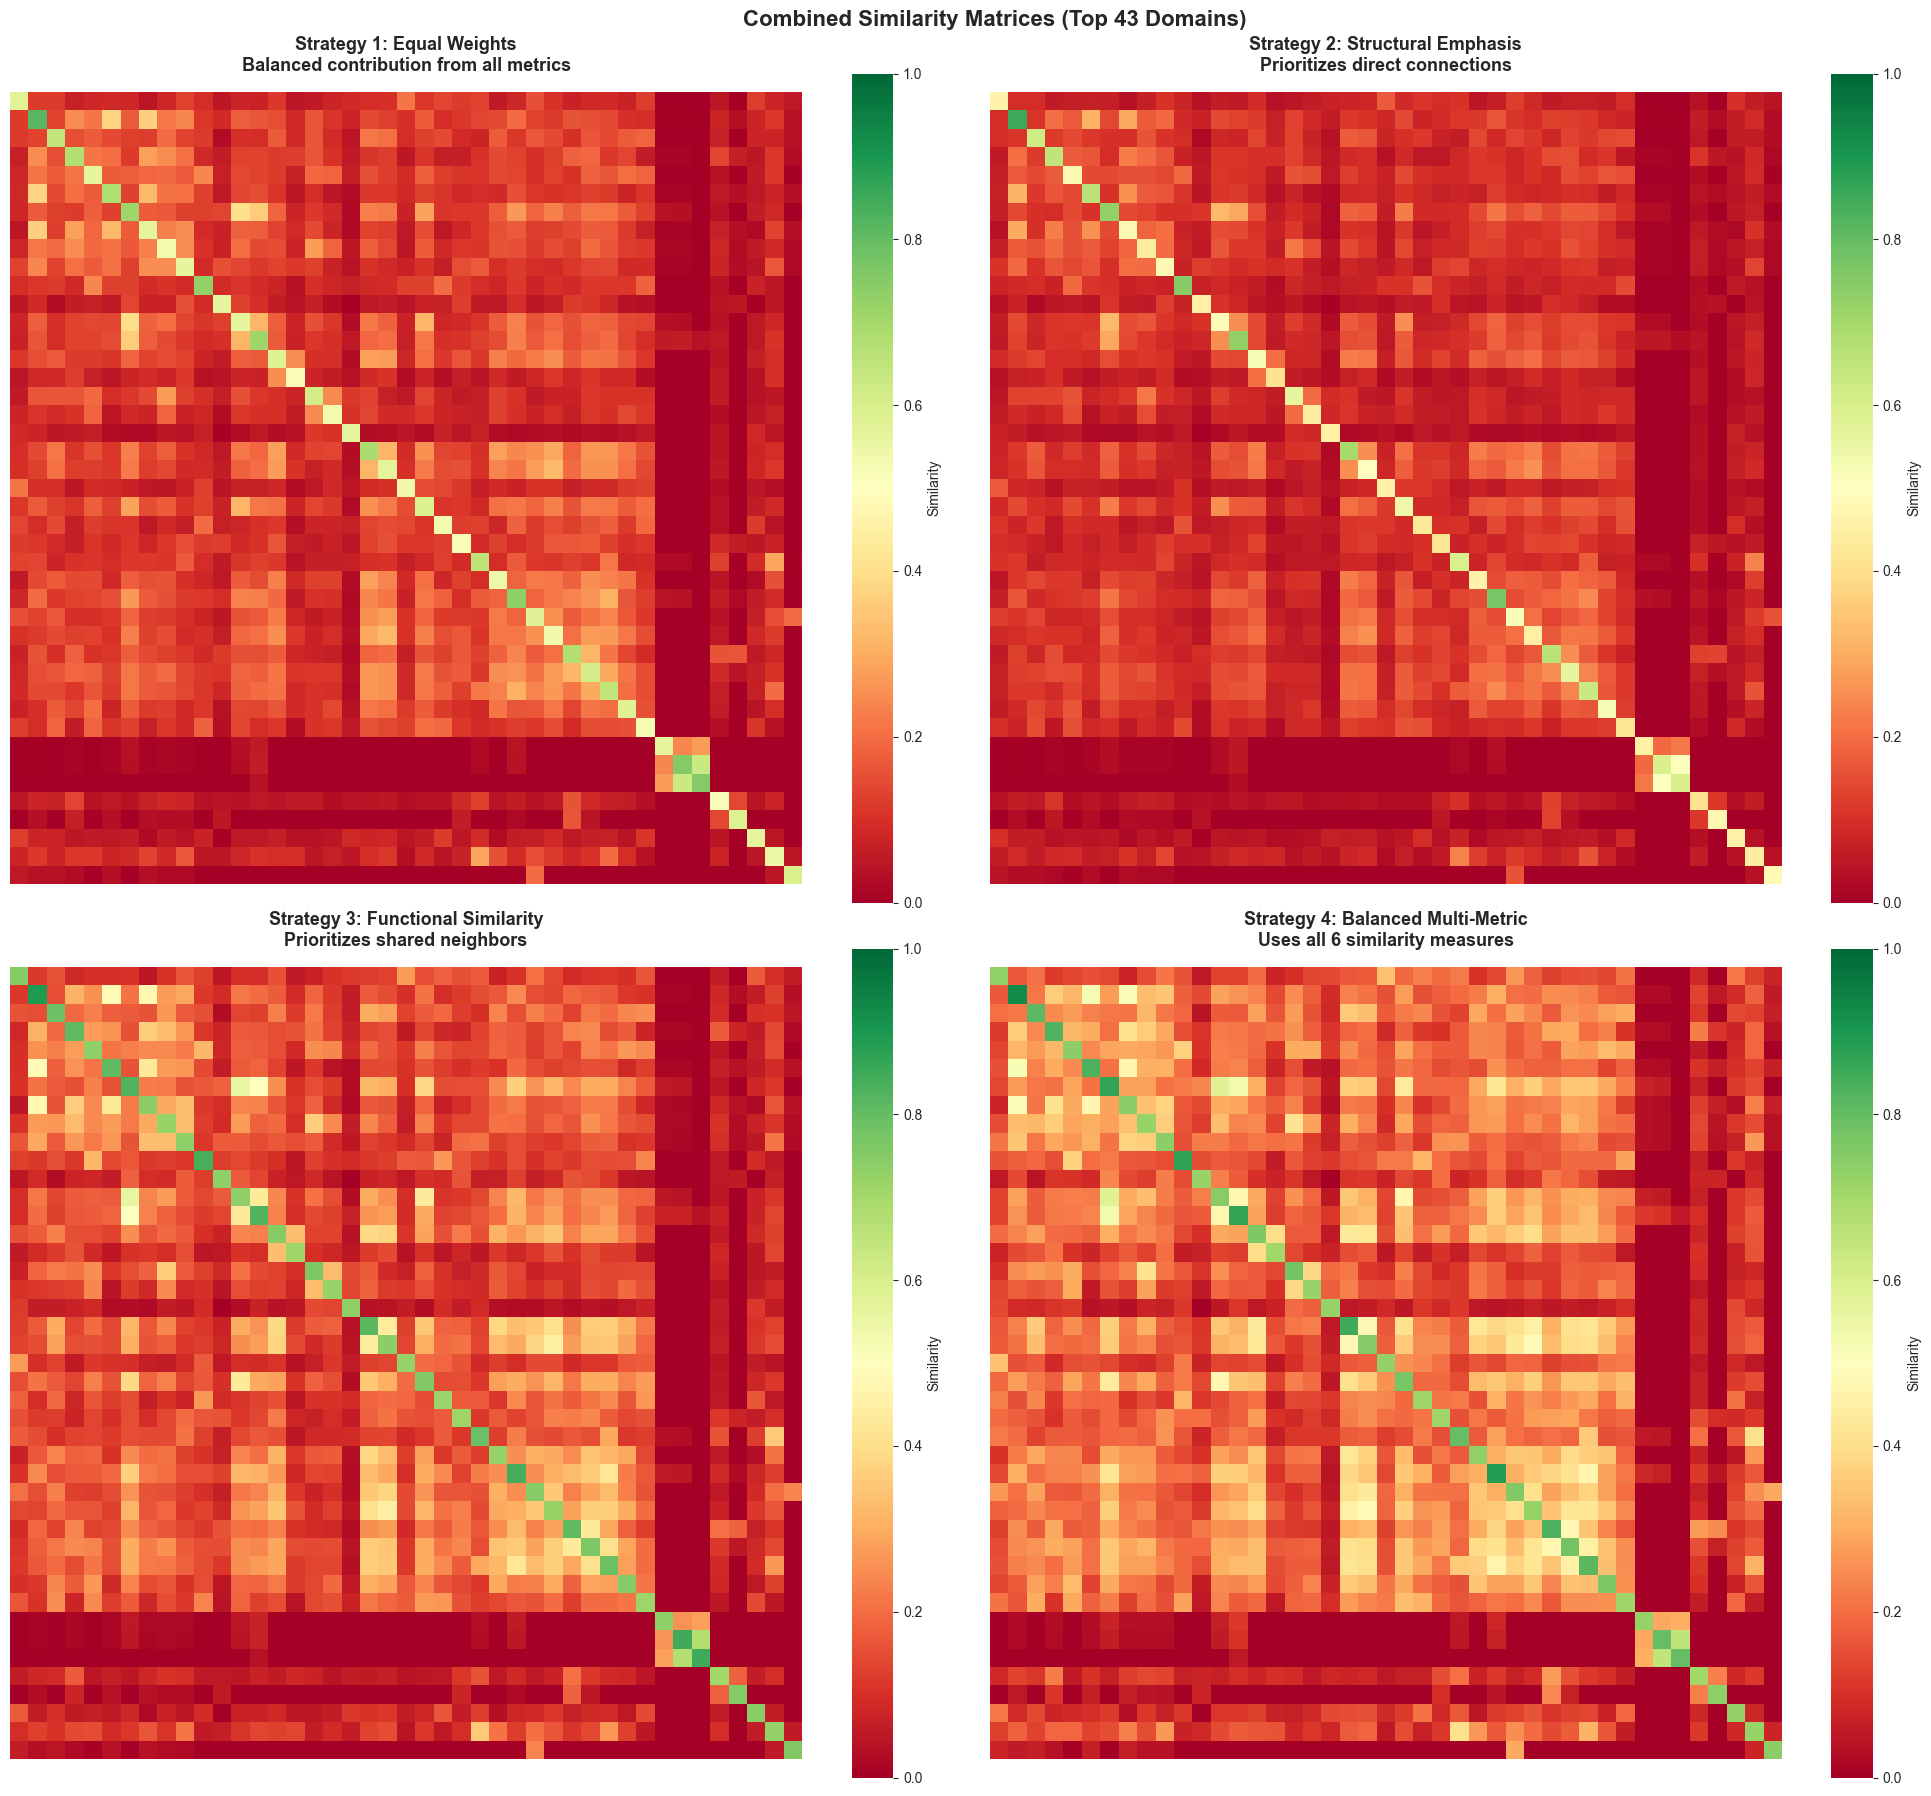

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20, 18))

vis_combined_equal = combined_equal
vis_combined_structural = combined_structural
vis_combined_functional = combined_functional
vis_combined_balanced = combined_balanced

sns.heatmap(
    vis_combined_equal,
    cmap="RdYlGn",
    square=True,
    cbar_kws={"label": "Similarity"},
    ax=axes[0, 0],
    xticklabels=False,
    yticklabels=False,
    vmin=0,
    vmax=1,
)
axes[0, 0].set_title(
    "Strategy 1: Equal Weights\nBalanced contribution from all metrics",
    fontsize=13,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    vis_combined_structural,
    cmap="RdYlGn",
    square=True,
    cbar_kws={"label": "Similarity"},
    ax=axes[0, 1],
    xticklabels=False,
    yticklabels=False,
    vmin=0,
    vmax=1,
)
axes[0, 1].set_title(
    "Strategy 2: Structural Emphasis\nPrioritizes direct connections",
    fontsize=13,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    vis_combined_functional,
    cmap="RdYlGn",
    square=True,
    cbar_kws={"label": "Similarity"},
    ax=axes[1, 0],
    xticklabels=False,
    yticklabels=False,
    vmin=0,
    vmax=1,
)
axes[1, 0].set_title(
    "Strategy 3: Functional Similarity\nPrioritizes shared neighbors",
    fontsize=13,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    vis_combined_balanced,
    cmap="RdYlGn",
    square=True,
    cbar_kws={"label": "Similarity"},
    ax=axes[1, 1],
    xticklabels=False,
    yticklabels=False,
    vmin=0,
    vmax=1,
)
axes[1, 1].set_title(
    "Strategy 4: Balanced Multi-Metric\nUses all 6 similarity measures",
    fontsize=13,
    fontweight="bold",
    pad=15,
)

plt.suptitle(
    f"Combined Similarity Matrices (Top {len(vis_domain_names)} Domains)",
    fontsize=16,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

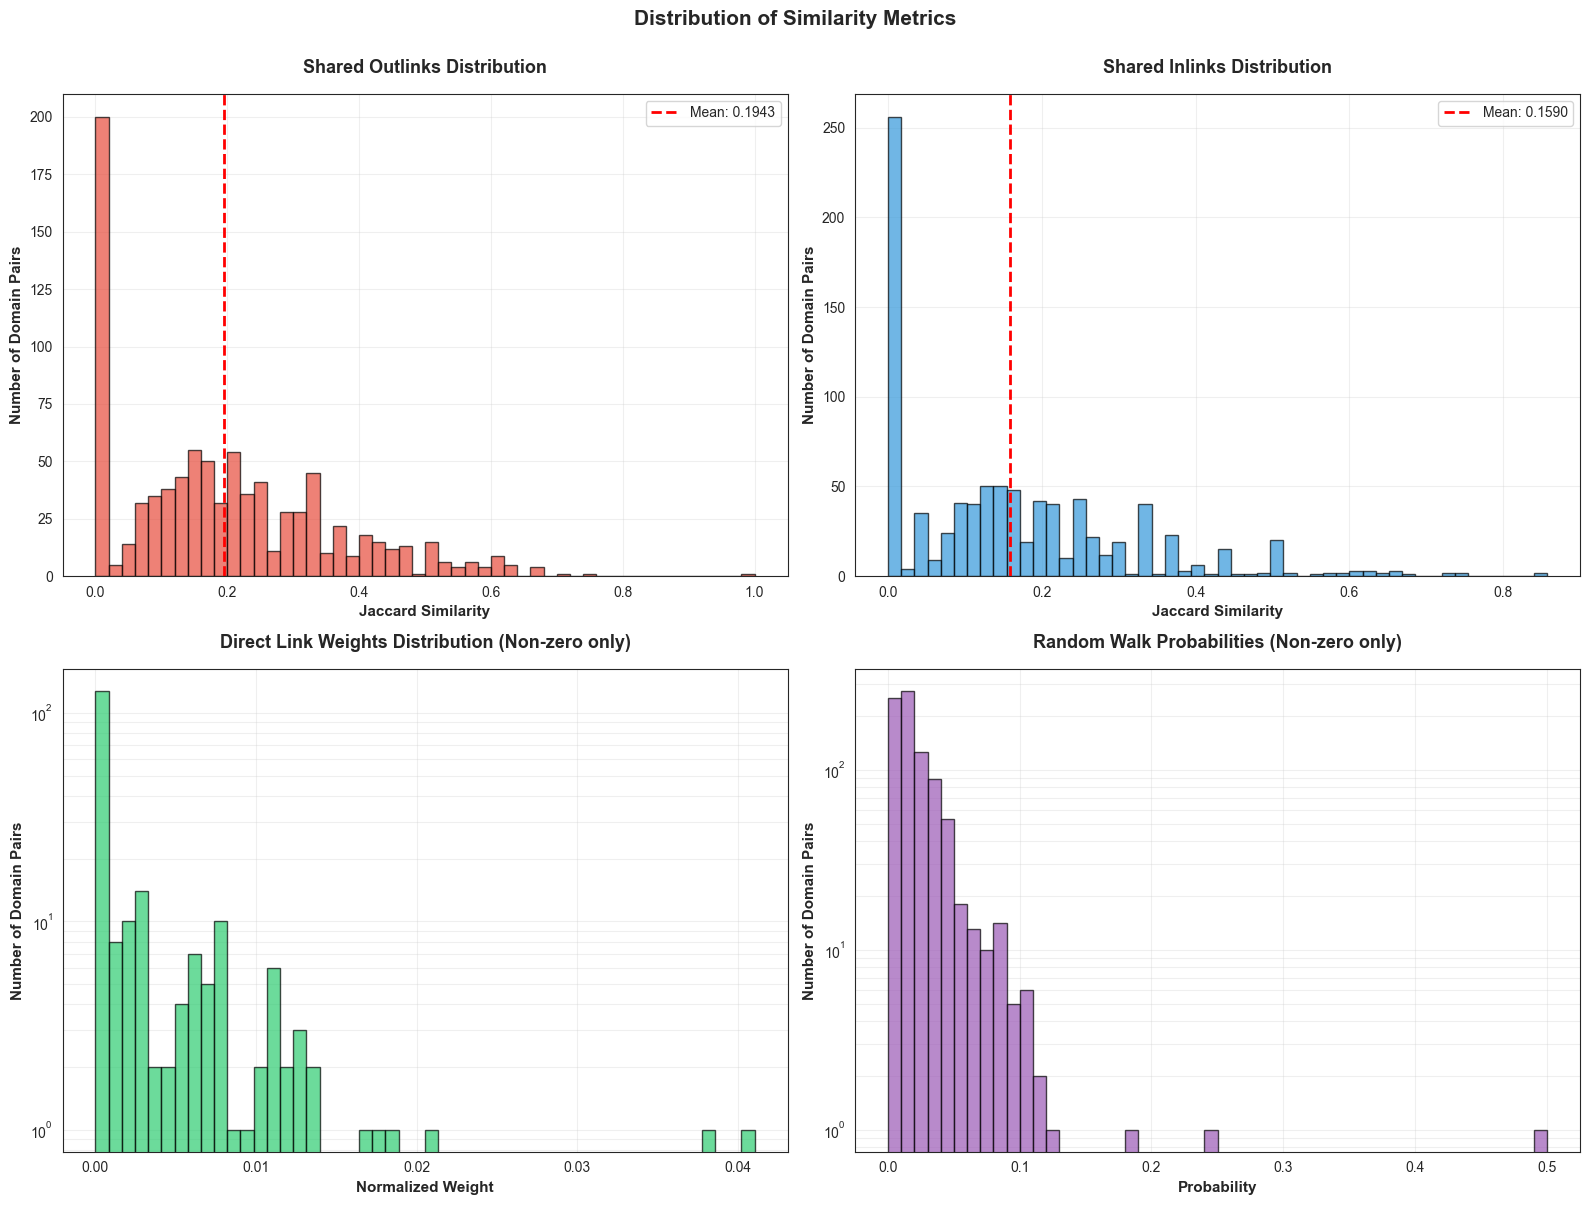

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

triu_indices = np.triu_indices(n_domains, k=1)

# Outlink Jaccard
axes[0, 0].hist(
    outlink_jaccard[triu_indices],
    bins=50,
    color="#e74c3c",
    alpha=0.7,
    edgecolor="black",
)
axes[0, 0].set_xlabel("Jaccard Similarity", fontsize=11, fontweight="bold")
axes[0, 0].set_ylabel("Number of Domain Pairs", fontsize=11, fontweight="bold")
axes[0, 0].set_title(
    "Shared Outlinks Distribution", fontsize=13, fontweight="bold", pad=15
)
axes[0, 0].axvline(
    outlink_jaccard[triu_indices].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {outlink_jaccard[triu_indices].mean():.4f}",
)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Inlink Jaccard
axes[0, 1].hist(
    inlink_jaccard[triu_indices], bins=50, color="#3498db", alpha=0.7, edgecolor="black"
)
axes[0, 1].set_xlabel("Jaccard Similarity", fontsize=11, fontweight="bold")
axes[0, 1].set_ylabel("Number of Domain Pairs", fontsize=11, fontweight="bold")
axes[0, 1].set_title(
    "Shared Inlinks Distribution", fontsize=13, fontweight="bold", pad=15
)
axes[0, 1].axvline(
    inlink_jaccard[triu_indices].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {inlink_jaccard[triu_indices].mean():.4f}",
)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Direct Weights (log scale for better visualization)
weights_nonzero = direct_weights_normalized[triu_indices]
weights_nonzero = weights_nonzero[weights_nonzero > 0]
axes[1, 0].hist(weights_nonzero, bins=50, color="#2ecc71", alpha=0.7, edgecolor="black")
axes[1, 0].set_xlabel("Normalized Weight", fontsize=11, fontweight="bold")
axes[1, 0].set_ylabel("Number of Domain Pairs", fontsize=11, fontweight="bold")
axes[1, 0].set_title(
    "Direct Link Weights Distribution (Non-zero only)",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
axes[1, 0].set_yscale("log")
axes[1, 0].grid(alpha=0.3, which="both")

# Random Walk
walk_nonzero = random_walk_symmetric[triu_indices]
walk_nonzero = walk_nonzero[walk_nonzero > 0]
axes[1, 1].hist(walk_nonzero, bins=50, color="#9b59b6", alpha=0.7, edgecolor="black")
axes[1, 1].set_xlabel("Probability", fontsize=11, fontweight="bold")
axes[1, 1].set_ylabel("Number of Domain Pairs", fontsize=11, fontweight="bold")
axes[1, 1].set_title(
    "Random Walk Probabilities (Non-zero only)", fontsize=13, fontweight="bold", pad=15
)
axes[1, 1].set_yscale("log")
axes[1, 1].grid(alpha=0.3, which="both")

plt.suptitle(
    "Distribution of Similarity Metrics", fontsize=15, fontweight="bold", y=1.0
)
plt.tight_layout()
plt.show()

## Clustering

In [30]:
import community as community_louvain

G_weighted = nx.Graph()
for i, domain1 in enumerate(all_domains):
    for j, domain2 in enumerate(all_domains):
        if i < j and combined_balanced[i, j] > 0:
            G_weighted.add_edge(domain1, domain2, weight=combined_balanced[i, j])

print(
    f"Weighted graph: {G_weighted.number_of_nodes():,} nodes, {G_weighted.number_of_edges():,} edges"
)

Weighted graph: 43 nodes, 863 edges


### Method 1. Louvain Community Detection

Louvain: 5 clusters, Modularity: 0.0621

LOUVAIN CLUSTERS - ALL DOMAINS

Cluster 0 (9 domains):
--------------------------------------------------------------------------------
  miasteczko.agh.edu.pl                              (degree: 13)
  oferta-badawcza.agh.edu.pl                         (degree: 9)
  rownosc.agh.edu.pl                                 (degree: 9)
  dzp.agh.edu.pl                                     (degree: 8)
  swfis.agh.edu.pl                                   (degree: 8)
  cwp.agh.edu.pl                                     (degree: 7)
  ckim.agh.edu.pl                                    (degree: 7)
  informatyka.podyplomowe.agh.edu.pl                 (degree: 4)
  old.skos.agh.edu.pl                                (degree: 4)

Cluster 1 (9 domains):
--------------------------------------------------------------------------------
  agh.edu.pl                                         (degree: 70)
  skos.agh.edu.pl                                    (degree: 46)


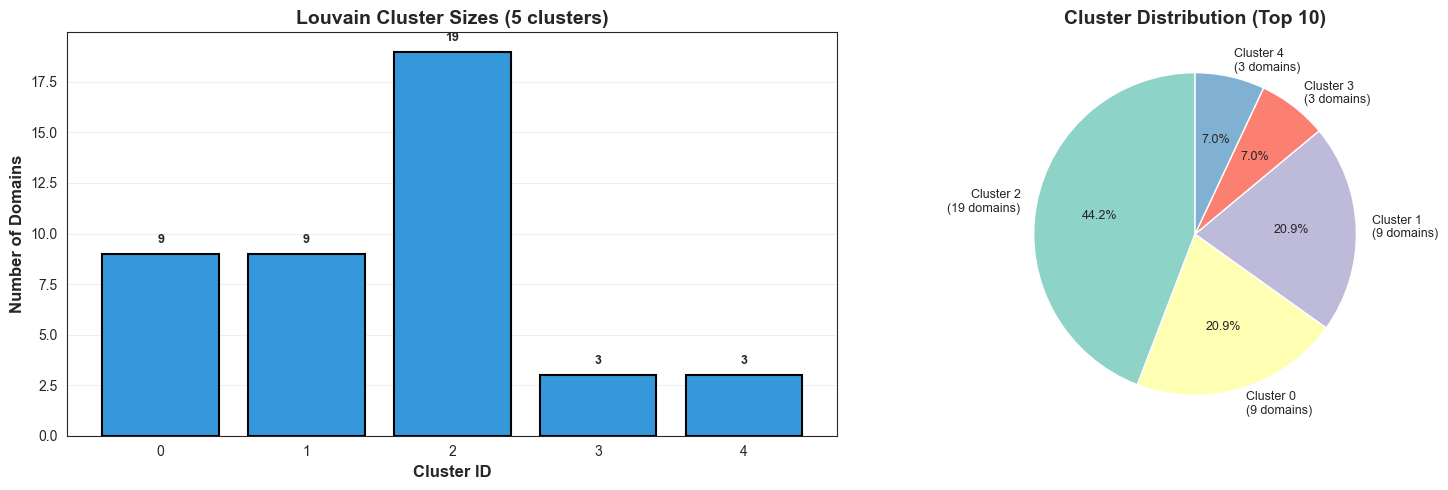


Total: 5 clusters


In [35]:
louvain_communities = community_louvain.best_partition(G_weighted, random_state=42)
louvain_labels = np.array([louvain_communities[domain] for domain in all_domains])
n_louvain_clusters = len(set(louvain_labels))
louvain_modularity = community_louvain.modularity(louvain_communities, G_weighted)

print(f"Louvain: {n_louvain_clusters} clusters, Modularity: {louvain_modularity:.4f}")

louvain_df = pd.DataFrame(
    {
        "domain": all_domains,
        "cluster": louvain_labels,
        "degree": [G.degree(d) for d in all_domains],
    }
).sort_values(["cluster", "degree"], ascending=[True, False])

print("\n" + "=" * 80)
print("LOUVAIN CLUSTERS - ALL DOMAINS")
print("=" * 80)

for cluster_id in sorted(set(louvain_labels)):
    cluster_domains = louvain_df[louvain_df["cluster"] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_domains)} domains):")
    print("-" * 80)
    for idx, row in cluster_domains.iterrows():
        print(f"  {row['domain']:50s} (degree: {row['degree']})")

louvain_sizes = pd.Series(louvain_labels).value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(
    range(n_louvain_clusters),
    louvain_sizes.values,
    color="#3498db",
    edgecolor="black",
    linewidth=1.5,
)
axes[0].set_xlabel("Cluster ID", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Number of Domains", fontsize=12, fontweight="bold")
axes[0].set_title(
    f"Louvain Cluster Sizes ({n_louvain_clusters} clusters)",
    fontsize=14,
    fontweight="bold",
)
axes[0].grid(axis="y", alpha=0.3)

for i, v in enumerate(louvain_sizes.values):
    axes[0].text(
        i,
        v + max(louvain_sizes.values) * 0.02,
        str(v),
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=9,
    )

top_10 = louvain_sizes.nlargest(10)
other = louvain_sizes.iloc[10:].sum() if len(louvain_sizes) > 10 else 0
labels = [f"Cluster {i}\n({s} domains)" for i, s in zip(top_10.index, top_10.values)]
sizes = list(top_10.values)
if other > 0:
    labels.append(f"Other Clusters\n({other} domains)")
    sizes.append(other)

axes[1].pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=plt.cm.Set3(range(len(sizes))),
    textprops={"fontsize": 9},
)
axes[1].set_title("Cluster Distribution (Top 10)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print(f"Total: {n_louvain_clusters} clusters")
print("=" * 80)